In [2]:
import numpy as np
import pandas as pd
import cv2
import os
from glob import glob
import matplotlib.pyplot as plt
import pickle
from keras.applications.resnet import ResNet50
from keras.models import Model

<h3>Import Images</h3>

In [3]:
images_path = './Flickr_Data/Images/' 
images = glob(images_path+'*.jpg')
len(images)

8091

<h3>Image feature extraction</h3>

In [15]:
#import resnet50
resnet = ResNet50(include_top=True)
resnet_model = Model(inputs = resnet.input,outputs = resnet.layers[-2].output)
resnet_model.summary()

resnet_model.save('./models/resnet.h5')

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                        

/Users/yannietchi/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [16]:
images_features = {}
count = 0
for i in images:
    #read image using cv2
    img = cv2.imread(i)
    #Change image color to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # preprocess Image to shape used by model
    img = cv2.resize(img, (224,224)).reshape(1,224,224,3)
    
    #model prediction
    pred = resnet_model.predict(img,verbose=0).reshape(2048,)


    #grab only name of image without path   
    img_name = i.split('/')[-1]

    
    #save pred array to dictionary
    images_features[img_name] = pred
    
    count += 1
    
    if count > 1000:
        break
        
    elif count % 50 == 0:
        print(count)
    
    

50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000


<h3>Text preprocess</h3>

In [7]:
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from preprocessor import preprocess_captions

#Import captions
captions = open('./Flickr_Data/Flickr_TextData/Flickr8k.token.txt', 'rb').read().decode('utf-8').split('\n')

#create caption dictionary and track all words
word_counts, captions_dict = preprocess_captions(captions, images_features)


#record longest caption
MAX_LEN = 0
for image, captions in captions_dict.items():
    for caption in captions:
        if len(caption) > MAX_LEN:
            MAX_LEN = len(caption)  

#prep data for training
def generator(photo_features, captions_dict, max_len, vocab_size):
    """
    Generates batches of training data for a sequence-to-sequence model.

    Args:
    - photo_features (dict): A dictionary where keys are image identifiers and values are features extracted from the images.
    - captions_dict (dict): A dictionary where keys are image identifiers and values are lists of captions associated with the images.
    - max_len (int): The maximum length of the input sequence.
    - vocab_size (int): The size of the vocabulary.

    Returns:
    - X (list): A list of image features.
    - y_in (list): A list of input sequences (padded).
    - y_out (list): A list of output sequences (one-hot encoded).
    """
    X = []
    y_in = []
    y_out = []

    for image_id, captions_list in captions_dict.items():
        # Iterate over each caption for the current image
        for caption in captions_list:
            # Generate input-output pairs for each caption
            for i in range(1, len(caption)):
                # Prepare image features
                X.append(photo_features[image_id])

                # Prepare input sequence (prefix)
                input_seq = [caption[:i]]
                input_seq = pad_sequences(input_seq, maxlen=max_len, padding='post', truncating='post')[0]
                y_in.append(input_seq)

                # Prepare output sequence (next word)
                output_seq = caption[i]
                output_seq = to_categorical([output_seq], num_classes=vocab_size + 1)[0]
                y_out.append(output_seq)

    return X, y_in, y_out



X, y_in, y_out = generator(images_features, captions_dict, MAX_LEN, len(word_counts))

# convert to np array
X = np.array(X)
y_in = np.array(y_in, dtype='float64')
y_out = np.array(y_out, dtype='float64')

<h3>Model</h3>

In [38]:
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.utils import plot_model
from keras.models import Model, Sequential
from keras.layers import Input
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense, Flatten,Input, Convolution2D, Dropout, LSTM, TimeDistributed, Embedding, Bidirectional, Activation, RepeatVector,Concatenate
from keras.models import Sequential, Model
from keras.utils import plot_model

In [53]:
embedding_size = 128
max_len = MAX_LEN
vocab_size = len(word_counts) +1

image_model = Sequential()

image_model.add(Dense(embedding_size, input_shape=(2048,), activation='relu'))
image_model.add(RepeatVector(max_len))

image_model.summary()

language_model = Sequential()

language_model.add(Embedding(input_dim=vocab_size, output_dim=embedding_size, input_length=max_len))
language_model.add(LSTM(256, return_sequences=True))
language_model.add(TimeDistributed(Dense(embedding_size)))

language_model.summary()

conca = Concatenate()([image_model.output, language_model.output])
x = LSTM(128, return_sequences=True)(conca)
x = LSTM(512, return_sequences=False)(x)
x = Dense(vocab_size)(x)
out = Activation('softmax')(x)
model = Model(inputs=[image_model.input, language_model.input], outputs = out)

# model.load_weights("../input/model_weights.h5")
model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 128)               262272    
                                                                 
 repeat_vector_4 (RepeatVec  (None, 36, 128)           0         
 tor)                                                            
                                                                 
Total params: 262272 (1.00 MB)
Trainable params: 262272 (1.00 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 36, 128)           408576    
                                                                 
 lstm_12 (LSTM)              (None, 36, 256)           394240 

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


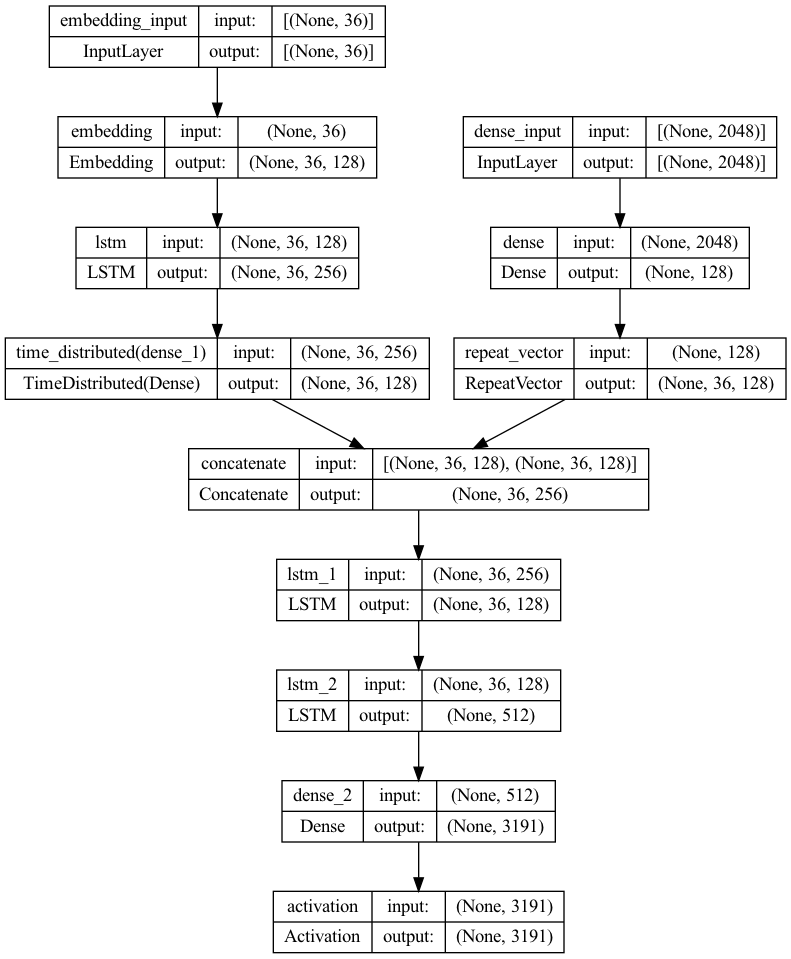

In [62]:
import tensorflow as tf
import matplotlib.pyplot as plt

# Assuming 'model' is your defined model
#tf.keras.utils.plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

# Alternatively, you can display the plot directly
#tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

# If you want to display the plot using matplotlib
from IPython.display import Image
Image(filename='model.png')



In [64]:
#train model
#model.fit([X, y_in], y_out, batch_size=512, epochs=50)

Epoch 1/50
127/127 [==============================] - 397s 3s/step - loss: 4.8958 - accuracy: 0.1340
Epoch 2/50
127/127 [==============================] - 1187s 9s/step - loss: 4.5451 - accuracy: 0.2025
Epoch 3/50
127/127 [==============================] - 3418s 27s/step - loss: 4.2568 - accuracy: 0.2511
Epoch 4/50
127/127 [==============================] - 2719s 22s/step - loss: 4.1230 - accuracy: 0.2625
Epoch 5/50
127/127 [==============================] - 466s 4s/step - loss: 4.0074 - accuracy: 0.2705
Epoch 6/50
127/127 [==============================] - 279s 2s/step - loss: 3.8985 - accuracy: 0.2802
Epoch 7/50
127/127 [==============================] - 268s 2s/step - loss: 3.7732 - accuracy: 0.2907
Epoch 8/50
127/127 [==============================] - 286s 2s/step - loss: 3.6288 - accuracy: 0.3068
Epoch 9/50
127/127 [==============================] - 405s 3s/step - loss: 3.4662 - accuracy: 0.3295
Epoch 10/50
127/127 [==============================] - 335s 3s/step - loss: 3.3254 - a

In [66]:
#savemodel
#model.save('model.keras')
#model.save_weights('mine_model_weights.keras')

In [10]:
#inverse dictionary
inv_dict = {v:k for k, v in word_counts.items()}


#with open('inv_dict.pkl', 'wb') as f:
   # pickle.dump(inv_dict, f)


#with open('word_dict.pkl', 'wb') as f:
    #pickle.dump(word_counts, f)